In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
import copy
from data_prep import ImageDataset

In [2]:
# Instantiating the dataset
dataset = ImageDataset()
# Splitting the dataset
split_data = random_split(dataset, [1248, 156, 156], generator=torch.Generator().manual_seed(54))
train_data, val_data, test_data = split_data

batch_size = 8

# Creating the dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [3]:
# Checking that the data has the correct shape
train_batch_data, train_batch_name = next(iter(train_dataloader))
print(f'Batch shape [batch_size, image_shape]: {train_batch_data.shape}')
print('Number of batches:', len(train_dataloader))

Batch shape [batch_size, image_shape]: torch.Size([8, 3, 28, 28])
Number of batches: 156


In [4]:
# Getting the number of classes for our data
labels = []
for x in train_data:
    labels.append(x[1])
    
num_classes = len(list(set(labels)))
print(num_classes)

26


In [5]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [6]:
# Defining the CNN Classifier
class CNNClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_channels3=64, num_classes=10):
        super(CNNClassif, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        self.cnn_layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, kernel_size=3, padding=2), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        self.linear_layer1 = nn.Sequential(nn.Linear(num_channels3*4*4, 64), nn.ReLU())
        self.linear_layer2 = nn.Sequential(nn.Linear(64, num_classes), nn.ReLU())
        
    def forward(self, x):
        w = self.cnn_layer1(x)
        y = self.cnn_layer2(w)
        z = self.cnn_layer3(y)
        #print(z.shape) # This shape will help you give correct input shape to linear_layer1
        z2 = z.reshape(z.shape[0], -1)
        lin1 = self.linear_layer1(z2)
        out = self.linear_layer2(lin1)
        return out 

In [7]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_channels3 = 64
num_classes = num_classes
model = CNNClassif(num_channels1, num_channels2, num_channels3, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# Initialization with manual seed and weights
torch.manual_seed(0)
model.apply(init_weights)

Total number of parameters:  99834


CNNClassif(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer1): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU()
  )
  (linear_layer2): Sequential(
    (0): Linear(in_features=64, out_features=26, bias=True)
    (1): ReLU()
  )
)

In [8]:
# Training function
def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Making a copy of the model
    model_tr = copy.deepcopy(model)
    model_tr.train()
    
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    loss_all_epochs = []
    
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            y_pred = model_tr.forward(images)
            loss = loss_fn(y_pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()

        loss_all_epochs.append(loss_current_epoch / (batch_index + 1))
        if verbose:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_current_epoch/(batch_index + 1):.4f}')
        
    return model_tr, loss_all_epochs

In [9]:
# Evaluation function
def eval_cnn_classifier(model, eval_dataloader):

    model.eval() 

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

Total number of CNN parameters:  99834
Epoch [1/30], Loss: 3.2586
Epoch [2/30], Loss: 3.2526
Epoch [3/30], Loss: 3.2437
Epoch [4/30], Loss: 3.2302
Epoch [5/30], Loss: 3.1968
Epoch [6/30], Loss: 3.0923
Epoch [7/30], Loss: 2.6951
Epoch [8/30], Loss: 2.1009
Epoch [9/30], Loss: 1.8269
Epoch [10/30], Loss: 1.6584
Epoch [11/30], Loss: 1.5484
Epoch [12/30], Loss: 1.4540
Epoch [13/30], Loss: 1.3858
Epoch [14/30], Loss: 1.2403
Epoch [15/30], Loss: 1.1507
Epoch [16/30], Loss: 1.0904
Epoch [17/30], Loss: 1.0308
Epoch [18/30], Loss: 0.9225
Epoch [19/30], Loss: 0.8303
Epoch [20/30], Loss: 0.7989
Epoch [21/30], Loss: 0.7446
Epoch [22/30], Loss: 0.6821
Epoch [23/30], Loss: 0.6841
Epoch [24/30], Loss: 0.6062
Epoch [25/30], Loss: 0.6053
Epoch [26/30], Loss: 0.6683
Epoch [27/30], Loss: 0.6385
Epoch [28/30], Loss: 0.5656
Epoch [29/30], Loss: 0.5510
Epoch [30/30], Loss: 0.5441


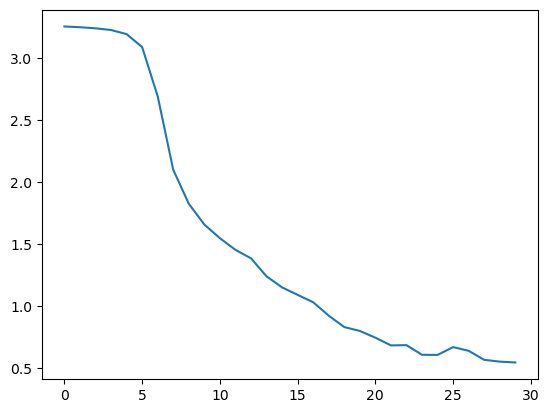

Accuracy of the network on the test images: 75.0%


In [10]:
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

model = CNNClassif(num_channels1, num_channels2, num_channels3, num_classes)
print('Total number of CNN parameters: ', sum(p.numel() for p in model.parameters()))
torch.manual_seed(0)
model.apply(init_weights)

model, loss_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)
torch.save(model.state_dict(), 'test_model.pt')
plt.plot(loss_total)
plt.show()

accuracy = eval_cnn_classifier(model, test_dataloader)
print(f'Accuracy of the network on the test images: {accuracy}%')